# AmeniDC
## See the cost of amenities in the District of Columbia

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 4 * matplotlib.rcParams['savefig.dpi']
import matplotlib.pylab as plt
from globals import AMENITY_TYPES

# Overview

1. generate grid points
1. query grid points for all amenity types and store in database
1. load amenities from other sources:
    1. load crime locations
    1. load tree locations
    1. load bikeshare locations
1. load property sale locations
1. derive features from amenities (or anti-amenities) 
    1. query features at distinct radii
    1. perform dimensionality reduction with random projections
    1. 

# Generate grid points
Space points on a grid of equilateral triangles

Prove that the covering radius should be $ \frac{h}{\sqrt{3}}$

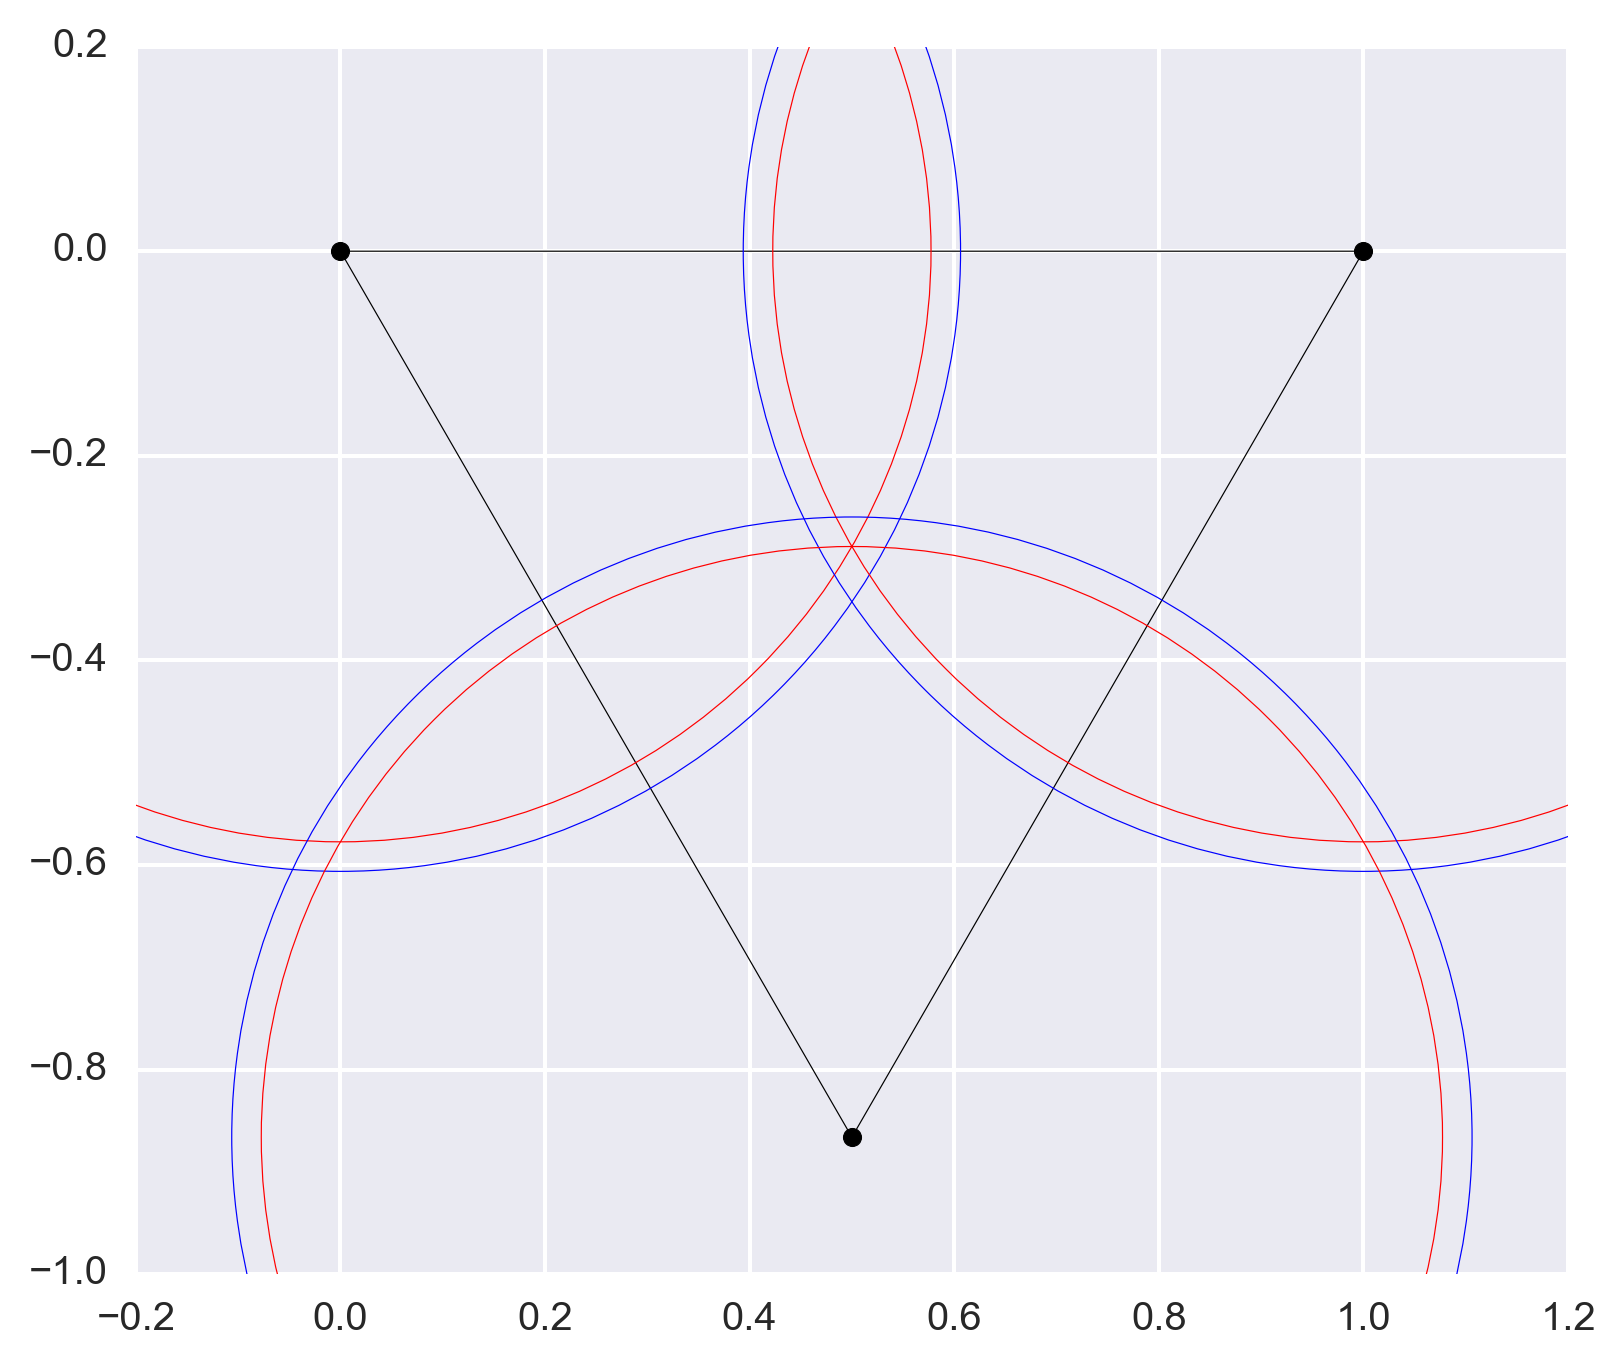

In [3]:
%autoreload 2
from demo_equilateral_grid import plot_radii

plot_radii()

52598 total queries required


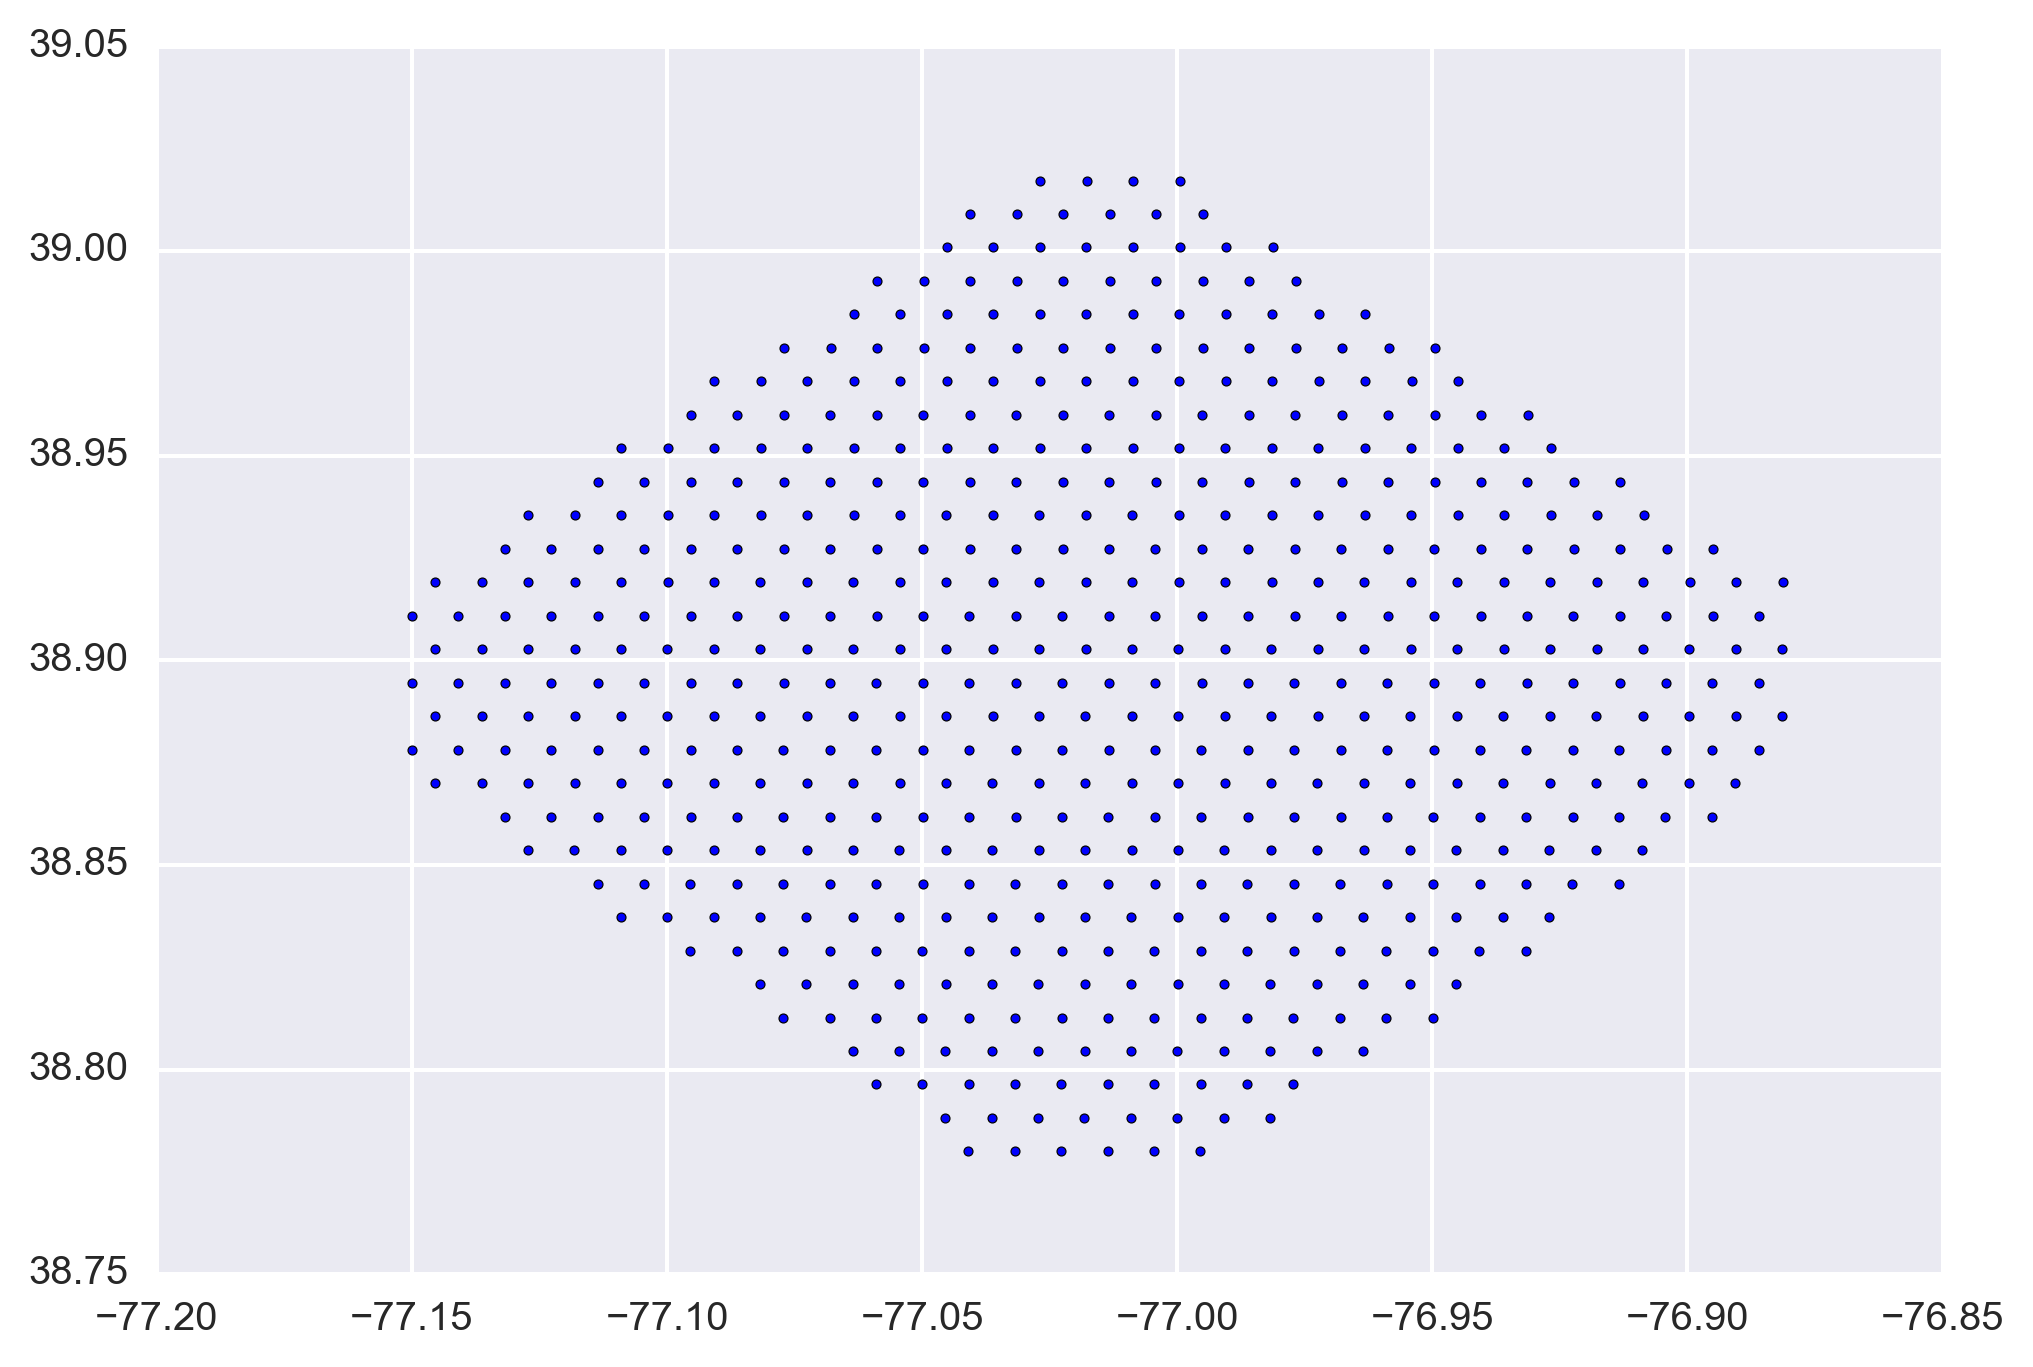

In [4]:
%autoreload 2
from grid_points import generate_grid_points

RADIUS = 500
amenity = 'spa'

lat,  lng,lat_lng_strs = generate_grid_points(radius=RADIUS)

fig,ax = plt.subplots(1,1)
ax.scatter(lng,lat,s=5)
print('{0} total queries required'.format(len(AMENITY_TYPES)*len(lat)))


In [10]:
import pandas as pd
df = pd.read_hdf('DATA/amenity_db.h5')

print(df.columns)
df.info()

Index([u'accounting', u'airport', u'amusement_park', u'aquarium',
       u'art_gallery', u'atm', u'bakery', u'bank', u'bar', u'beauty_salon',
       ...
       u'subway_station', u'synagogue', u'taxi_stand', u'train_station',
       u'transit_station', u'travel_agency', u'university', u'veterinary_care',
       u'vicinity', u'zoo'],
      dtype='object', length=101)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 70744 entries, 0 to 0
Columns: 101 entries, accounting to zoo
dtypes: float64(97), object(4)
memory usage: 55.1+ MB


Index([u'Unnamed: 0', u'SALEPRICE', u'LANDAREA', u'zipcode', u'bakery_count',
       u'bar_count', u'cafe_count', u'grocery_or_supermarket_count',
       u'movie_theater_count', u'park_count', u'pharmacy_count',
       u'restaurant_count', u'school_count', u'spa_count',
       u'subway_station_count', u'bakery_mean_rating', u'bar_mean_rating',
       u'cafe_mean_rating', u'grocery_or_supermarket_mean_rating',
       u'movie_theater_mean_rating', u'park_mean_rating',
       u'pharmacy_mean_rating', u'restaurant_mean_rating',
       u'school_mean_rating', u'spa_mean_rating',
       u'subway_station_mean_rating', u'bakery_mean_price_level',
       u'bar_mean_price_level', u'cafe_mean_price_level',
       u'grocery_or_supermarket_mean_price_level',
       u'pharmacy_mean_price_level', u'restaurant_mean_price_level',
       u'spa_mean_price_level', u'lat', u'lng', u'kmeans_spatial_label'],
      dtype='object')


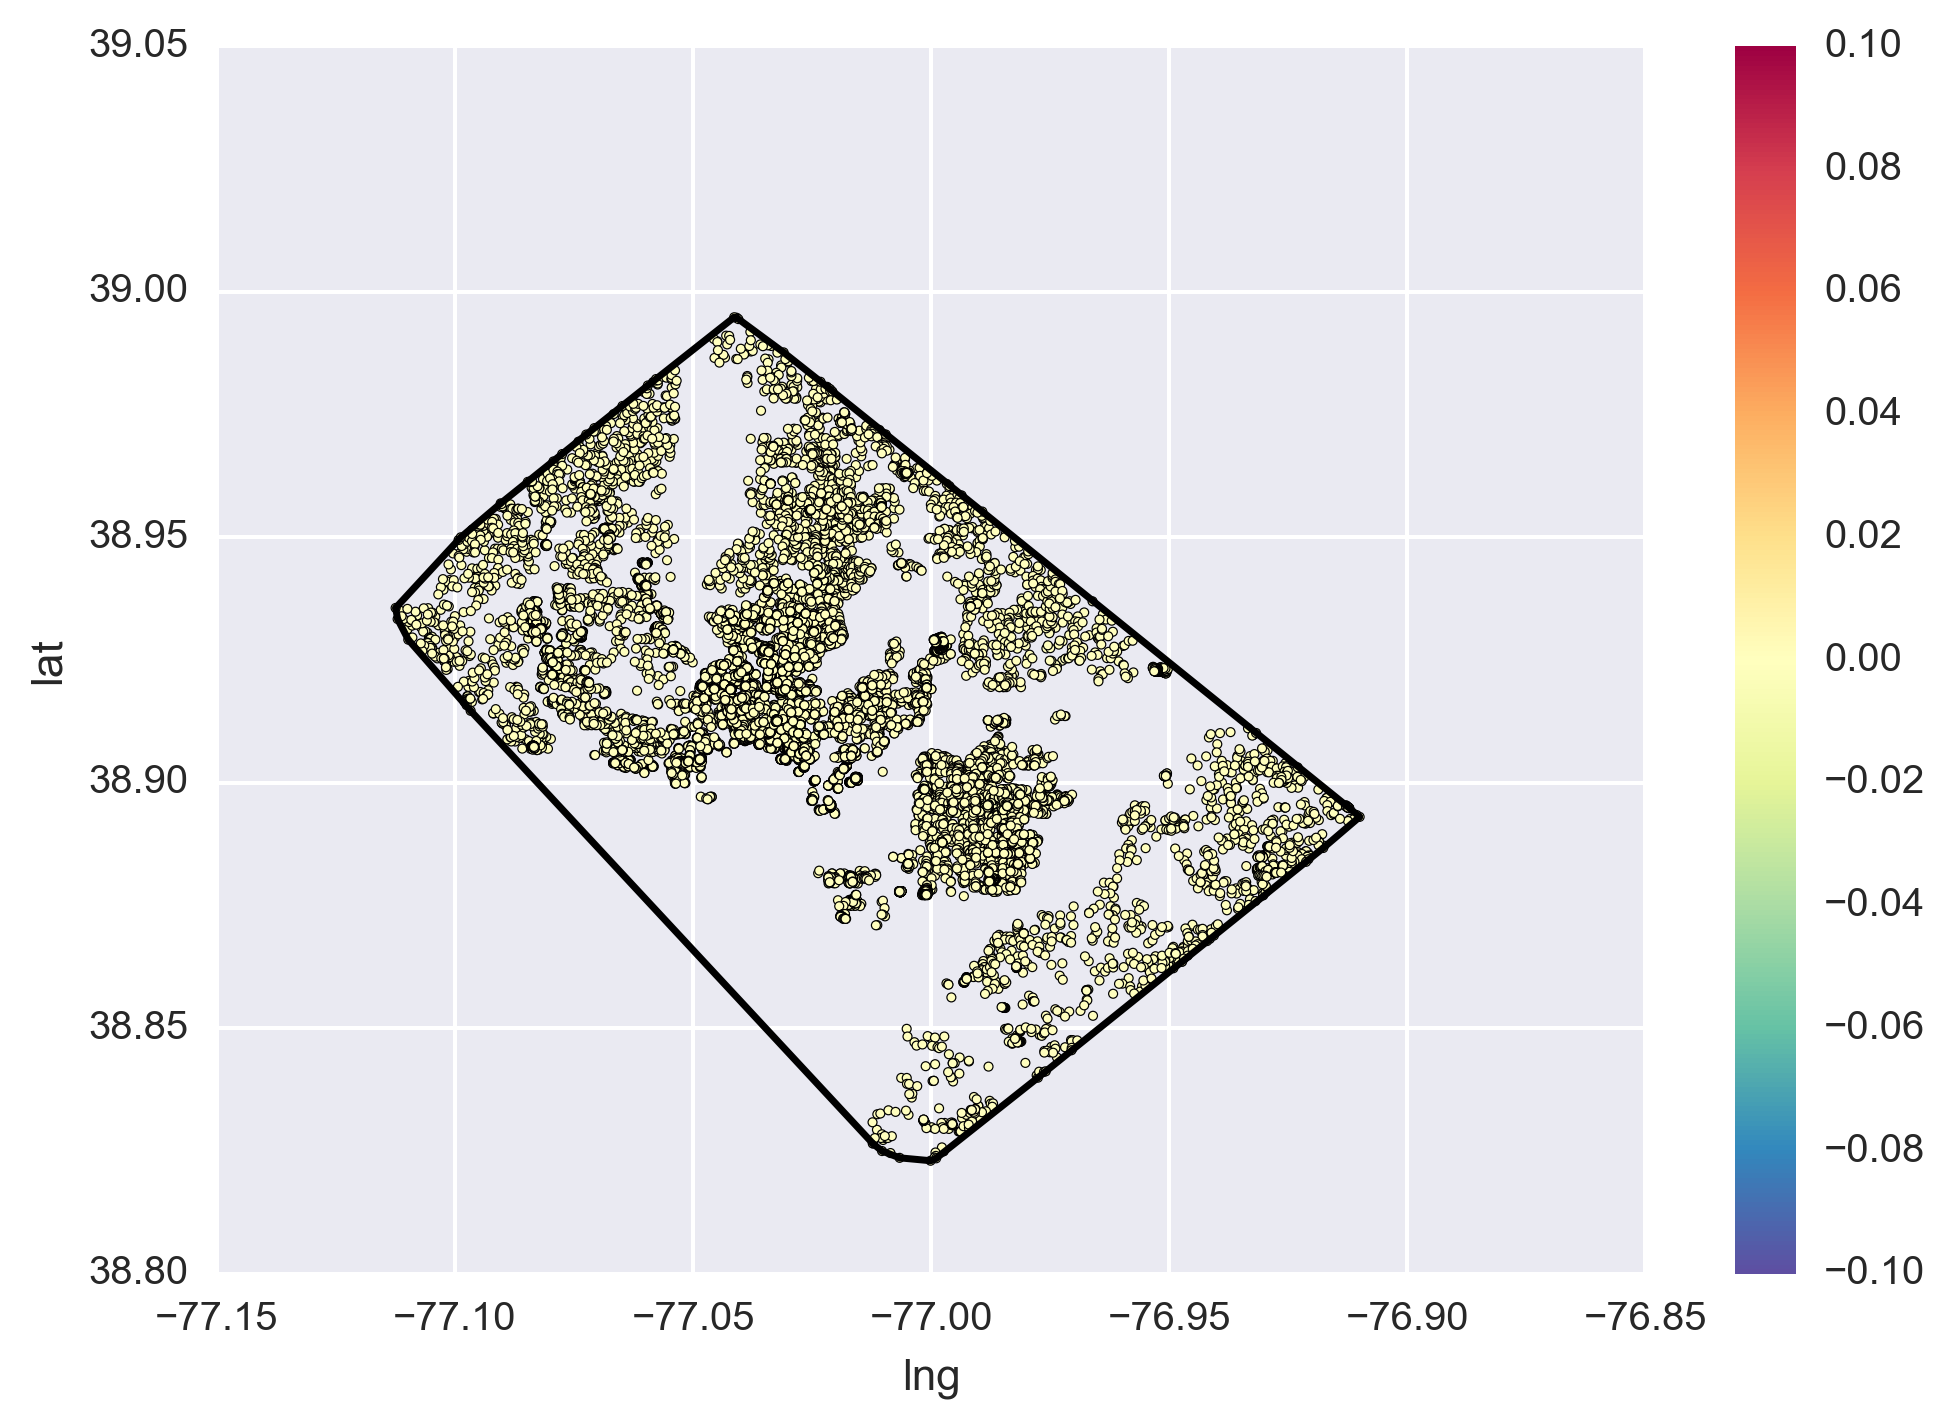

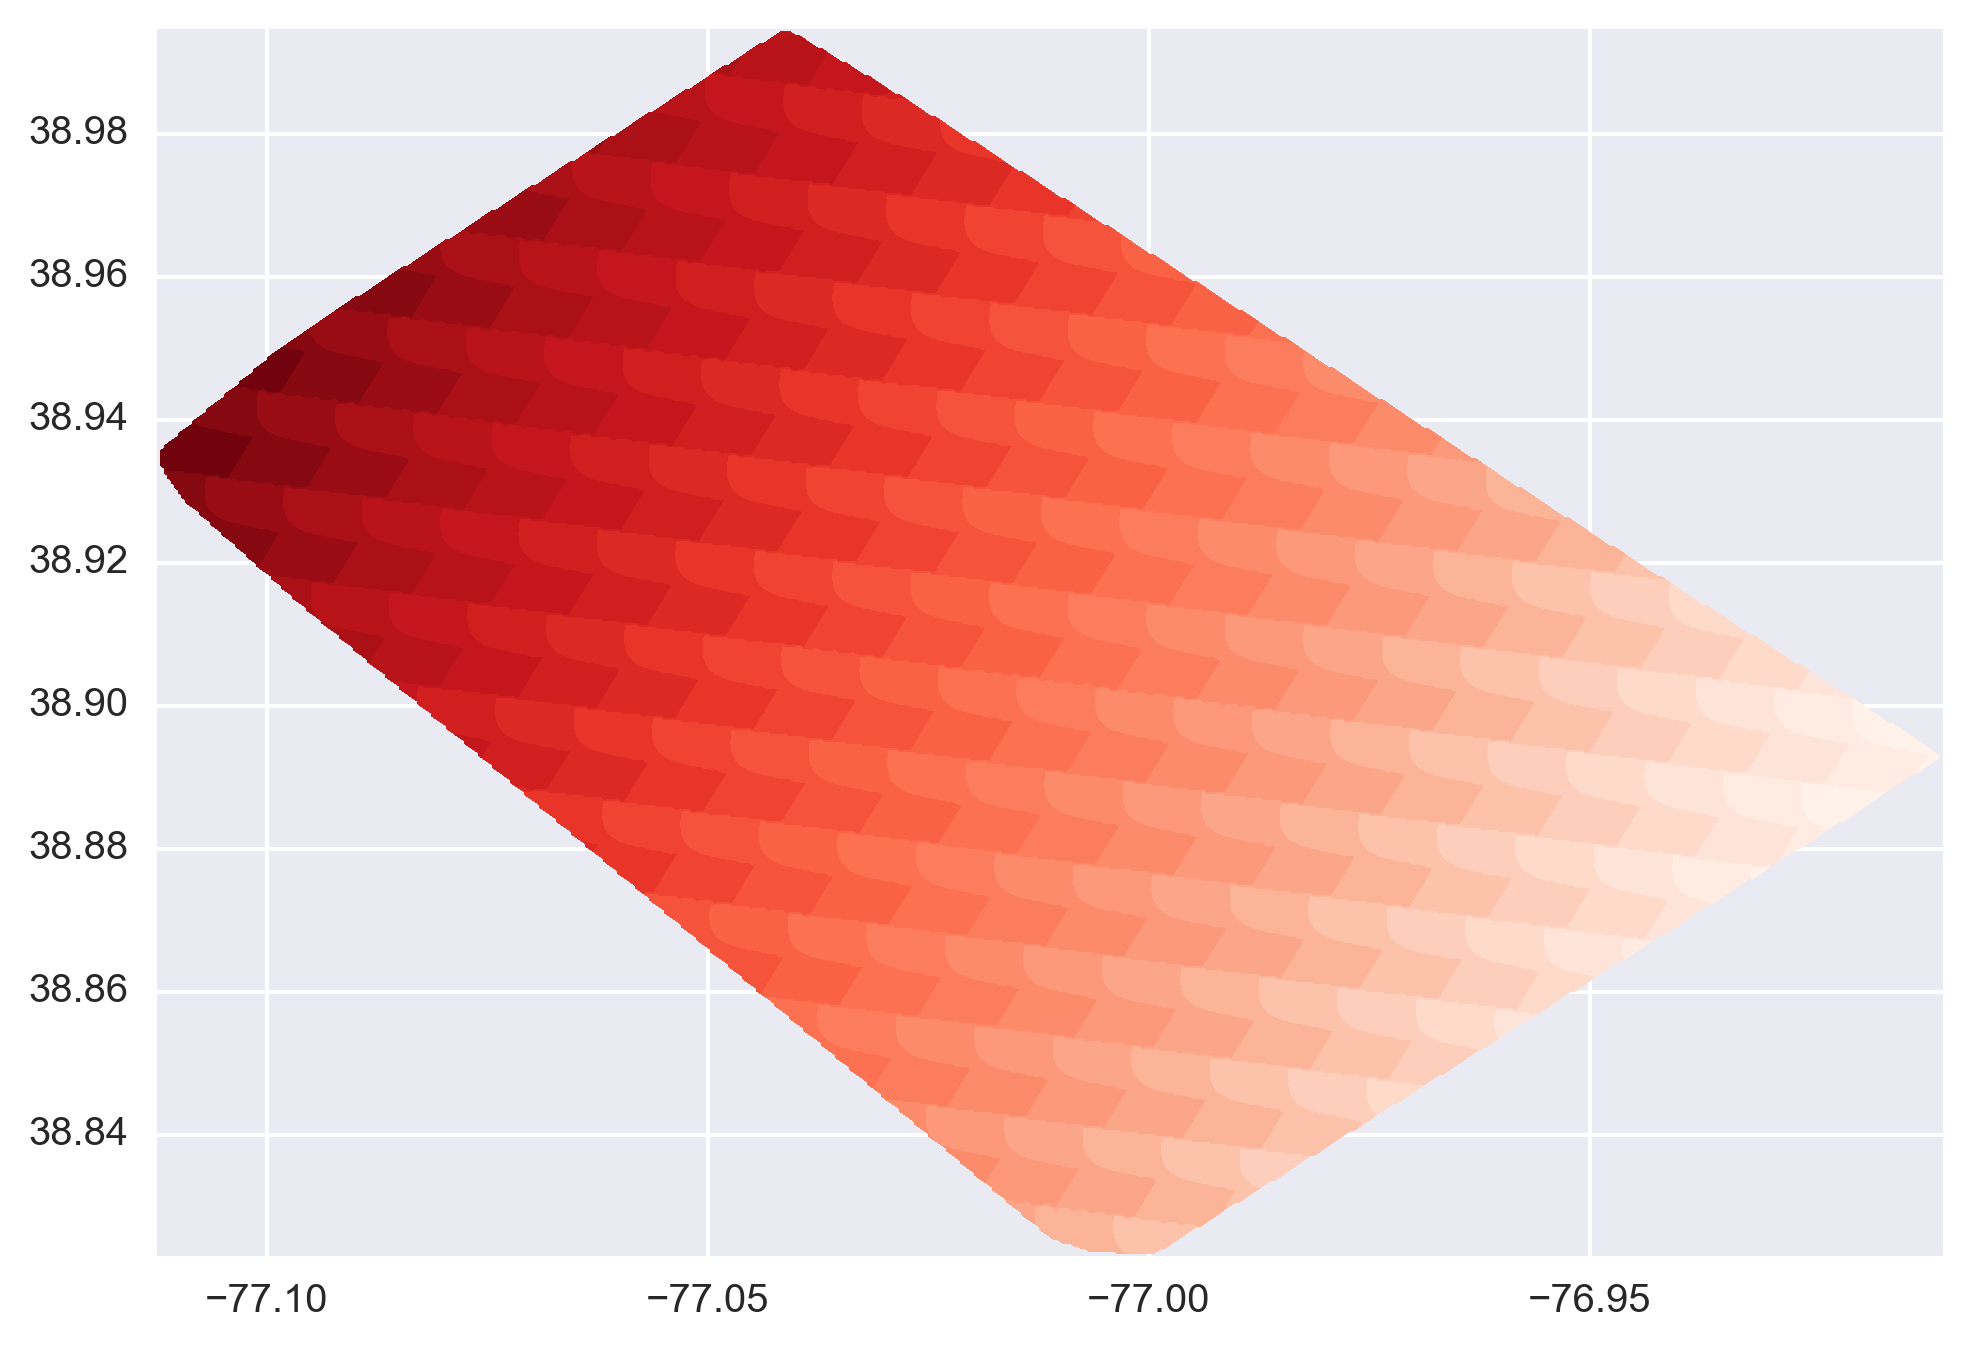

In [28]:
%autoreload 2
from convex_regions import create_convex_regions
from kernel_density import calc_kernel_density


# create_convex_regions(df_sale)
polygons = create_convex_regions(df_sale,n_clusters=1)

calc_kernel_density(df_sale.loc[:,['lng','lat']],polygons)

,Model,MSE
0,Mean Model,8.387142e+11
1,Radius,3.937340e+11
2,KNeighbors,1.494336e+11
3,Random Forest,1.250051e+11
4,Ada Boost,1.256777e+11


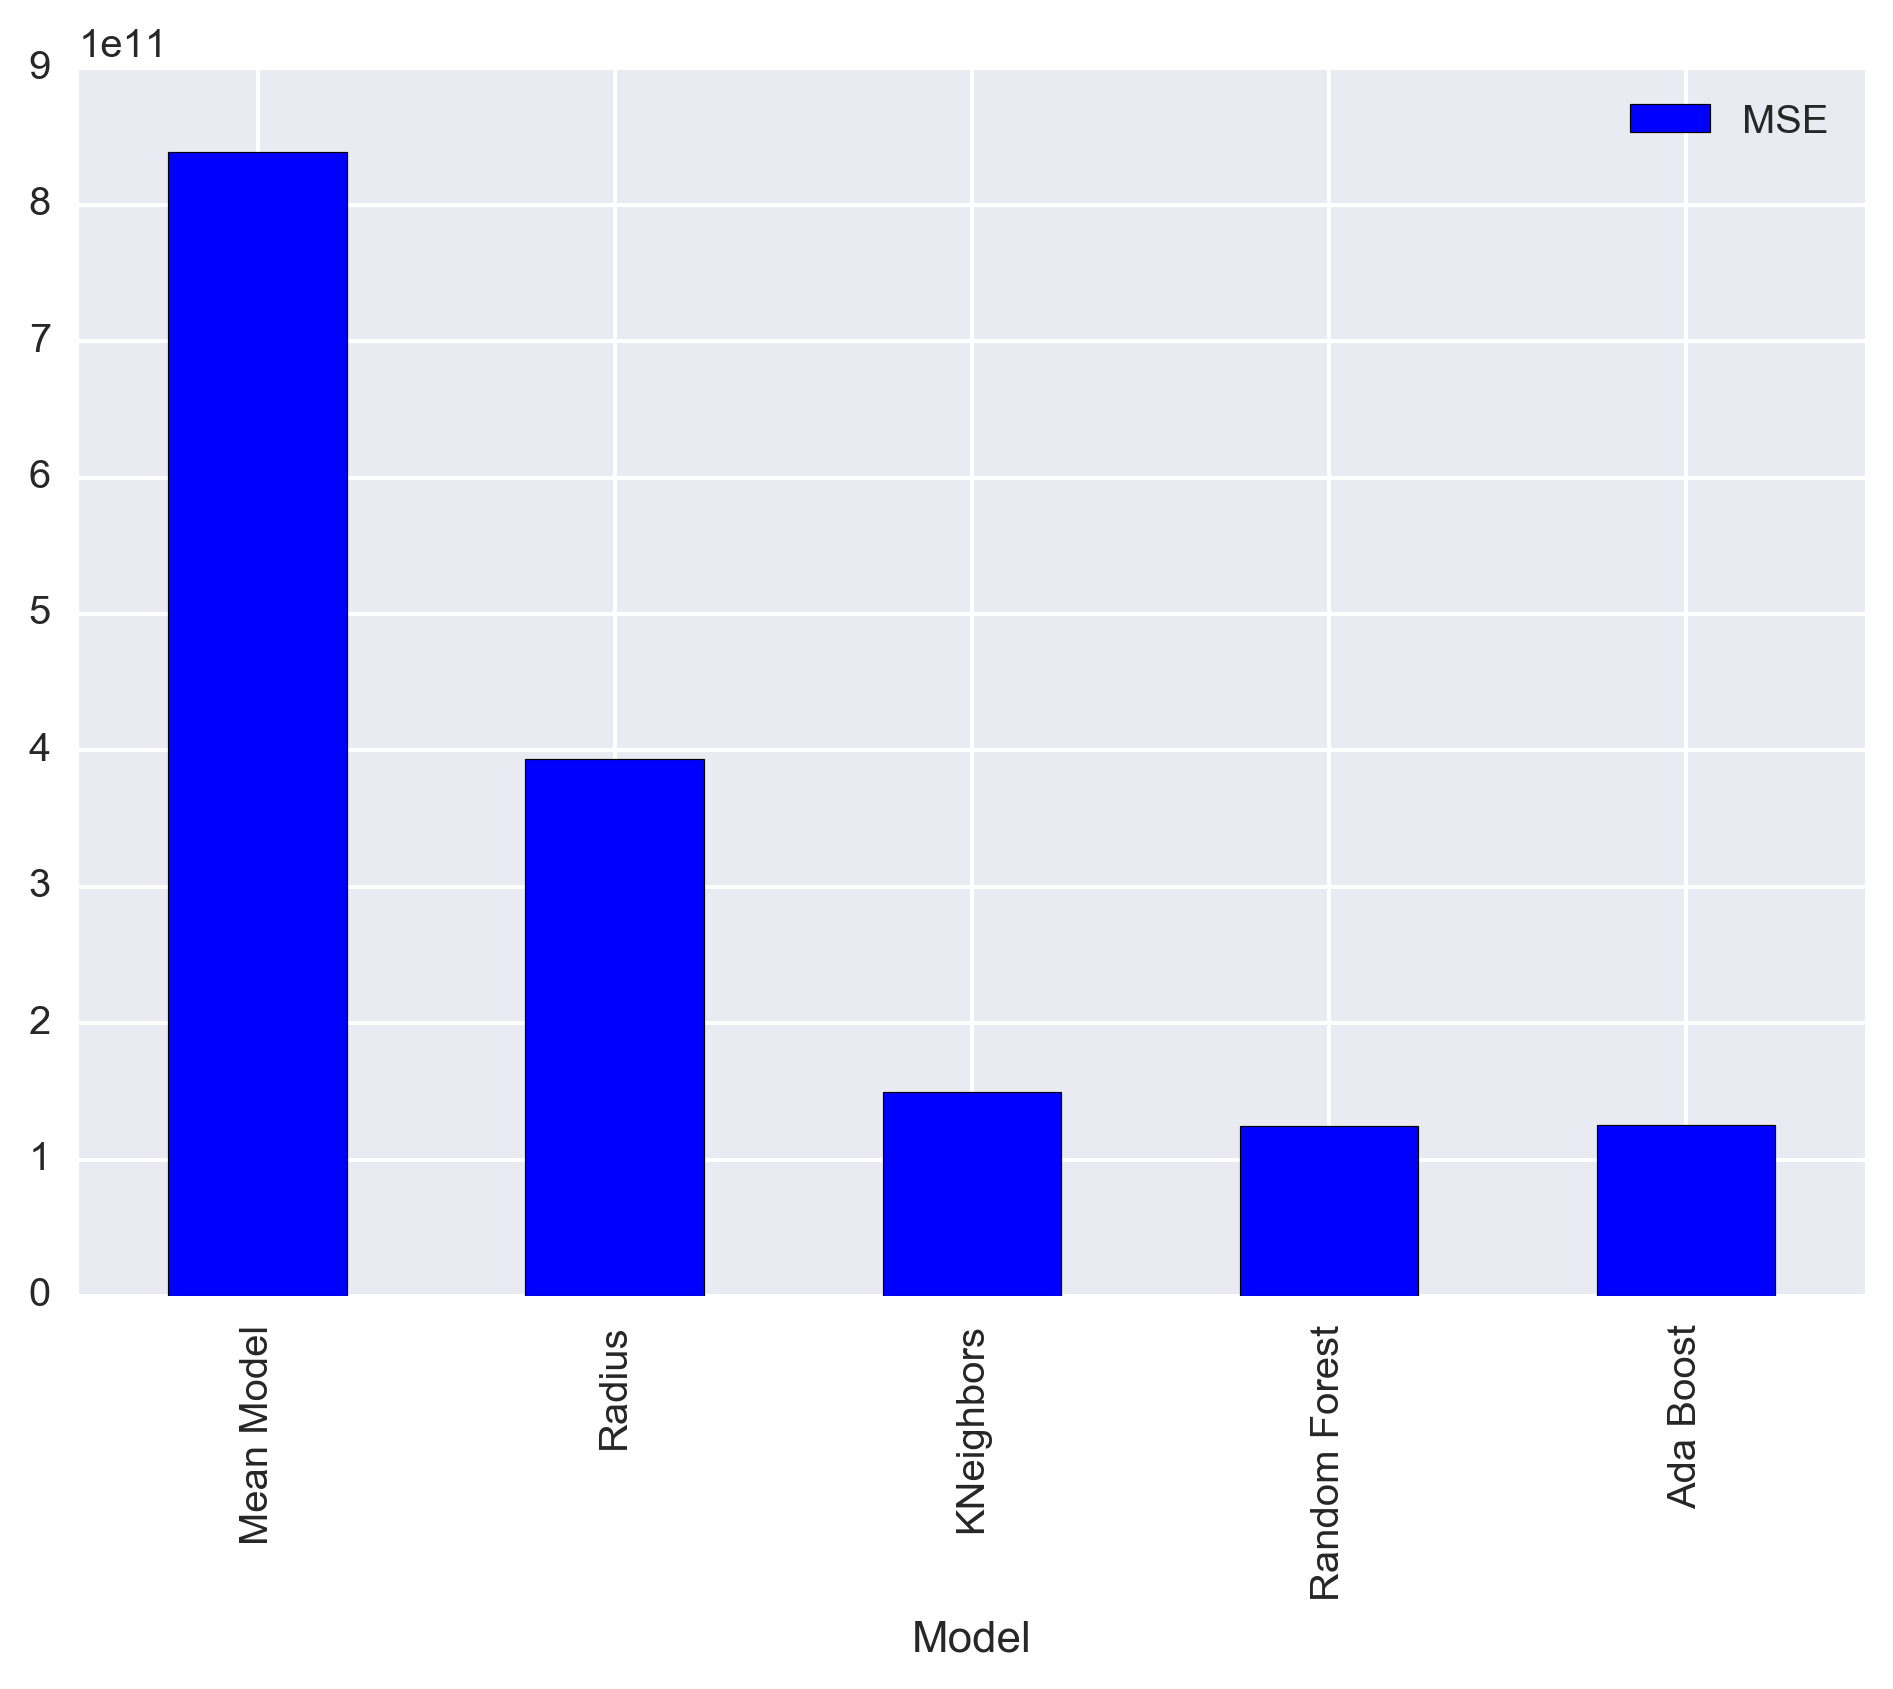

In [30]:
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn import cross_validation

X = df_sale[['lng','lat']]
y = df_sale.SALEPRICE
cv = cross_validation.ShuffleSplit(len(y), n_iter=20, test_size=0.2, random_state=42)
def compute_error(clf, X, y):
    return - cross_validation.cross_val_score(clf, X, y, cv=cv, scoring='mean_squared_error').mean()

clf_rad = RadiusNeighborsRegressor(radius=0.1,weights='distance').fit(X,y)
clf_knn = KNeighborsRegressor().fit(X,y)
clf_rf = RandomForestRegressor().fit(X,y)
clf_ada = AdaBoostRegressor().fit(X,y)

model_performance = pd.DataFrame([
    ("Mean Model", y.var()),
    ("Radius", compute_error(clf_rad, X, y)),
    ("KNeighbors", compute_error(clf_knn, X, y)),
    ("Random Forest", compute_error(clf_rf, X, y)),
    ("Ada Boost", compute_error(clf_rf, X, y)),
    ], columns=["Model", "MSE"])

model_performance.set_index("Model")
model_performance.plot(x="Model", y="MSE", kind="Bar")

model_performance


In [14]:
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('haversine')
X = df[['lat','lng']].sample(100)
dist.pairwise(X)

array([[ 0.        ,  0.01714181,  0.01557267, ...,  0.08776478,
         0.0086789 ,  0.03431057],
       [ 0.01714181,  0.        ,  0.02233289, ...,  0.09255932,
         0.02539029,  0.03836199],
       [ 0.01557267,  0.02233289,  0.        , ...,  0.07283264,
         0.01528369,  0.01880963],
       ..., 
       [ 0.08776478,  0.09255932,  0.07283264, ...,  0.        ,
         0.08333671,  0.05446264],
       [ 0.0086789 ,  0.02539029,  0.01528369, ...,  0.08333671,
         0.        ,  0.03205049],
       [ 0.03431057,  0.03836199,  0.01880963, ...,  0.05446264,
         0.03205049,  0.        ]])

In [ ]:
X = df[['lat','lng']].sample(100)

In [ ]:
from sklearn.decomposition import PCA

X = df[count_cols]
X = (X-X.mean())/X.std()
pca = PCA(n_components=10)

pd.concat((df[['SALEPRICE']],pd.DataFrame(pca.fit(X).transform(X))),axis=1).corr()

In [ ]:
from sklearn import cross_validation, grid_search

X = df[count_cols]
X = (X-X.mean())/X.std()
X = X.sample(10000)
y = df.loc[X.index,'SALEPRICE']
if 1:
  clf = PLSRegression(n_components=5)
  clf.fit(X,y)  
  print (np.abs(clf.predict(X).ravel()-y)).mean()

In [ ]:
from sklearn import cross_validation, grid_search
from sklearn import linear_model, neighbors, ensemble

if 0:
  X = df[count_cols]
  X = (X-X.mean())/X.std()
else:
  X = df[lat_lng_cols]
  X = (X-X.min())/(X.max()-X.min())
  
#X = X.sample(1000)
y = df.loc[X.index,'SALEPRICE']
if 0:
  clf = neighbors.KNeighborsRegressor(n_neighbors=1)
  if 1:
    pca = PCA(n_components=2)
    clf.fit(pca.fit(X).transform(X),y)
    print np.abs(clf.predict(pca.fit(X).transform(X))-y).mean()
  else:
    clf.fit(X,y)
    print np.abs(clf.predict(X)-y).mean()
else:
  if 1:
    param_grid = {'n_neighbors':range(1,6)}
    clf_CV = grid_search.GridSearchCV( neighbors.KNeighborsRegressor(),
                    param_grid=param_grid,
                    cv=cross_validation.ShuffleSplit(len(y), n_iter=20, 
                        test_size=0.2, random_state=42) )
  else:
    param_grid = {'min_samples_leaf':range(1,8)}
    clf_CV = grid_search.GridSearchCV( ensemble.RandomForestRegressor(),
                    param_grid=param_grid,
                    cv=cross_validation.ShuffleSplit(len(y), n_iter=20, 
                        test_size=0.2, random_state=42) )
  if 0:
    pca = PCA(n_components=10)
    clf_CV.fit(pca.fit(X).transform(X),y)
  else:
    clf_CV.fit(X,y)
    
  for key in param_grid.keys():
    grid_score_plotter(clf_CV,key,title='KNeighbors Cross-Validation')

  print clf_CV.best_params_
  


In [ ]:
pd.concat((clf_CV.predict(X)-y,df[rating_cols]),axis=1).corr()

In [ ]:
from sklearn.svm import NuSVR
from sklearn import cross_validation, grid_search

X = df[count_cols]
X = (X-X.mean())/X.std()cc
X = X.sample(1000)
y = df.loc[X.index,'SALEPRICE']
if 0:
  clf = NuSVR(C=1.0, nu=0.1)
  clf.fit(X,y)  
  (np.abs(clf.predict(X)-y)).mean()

param_grid = {"nu": np.linspace(0.05,0.7,4),"C": np.logspace(-1,1,3)}
clf_CV = grid_search.GridSearchCV( NuSVR(),
                param_grid=param_grid,
                cv=cross_validation.ShuffleSplit(len(y), n_iter=20, 
                    test_size=0.2, random_state=42) )
clf_CV.fit(X,y)

In [ ]:
for key in param_grid.keys():
  grid_score_plotter(clf_CV,key,title='CV NuSVR')

print clf_CV.best_params_

In [ ]:
from sklearn import cross_validation, grid_search, neighbors
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import cross_validation, grid_search, neighbors, ensemble
from sklearn.pipeline import Pipeline
from sklearn import linear_model

In [ ]:
def grid_score_plotter(cv,param,title=None,xlabel=None):
  cv_accuracy = pd.DataFrame.from_records(
      [(score.parameters[param],
        score.mean_validation_score)
       for score in cv.grid_scores_],
  columns=[param, 'accuracy'])

  f = plt.figure(figsize=(4,3))
  plt.plot(cv_accuracy[param], cv_accuracy.accuracy)
  if xlabel is not None:
    plt.xlabel(xlabel)
  else:
    plt.xlabel(param)
  plt.ylabel('accuracy')
  plt.title(title)
  plt.show()
  if title is not None:
    plt.savefig('./static/images/'+title.replace(' ','_')+'.png',frameon=False,dpi=450,pad_inches=0.1)

In [ ]:
class ColumnSelectTransformer(BaseEstimator, TransformerMixin):
  """
  Select columns of data from nd array
  """
  def __init__(self, columns, rescale=None):
    ''' columns must be list of strings '''
    self.columns = columns
    if rescale == "standard" or rescale=="range" or rescale==None:
      self.rescale = rescale
    else:
      raise NameError("rescale option must specify 'standard' or 'range'")

  def fit(self, X, y):
    return self

  def transform(self, X):
    ''' Assume X is pandas dataframe '''
    df = X[self.columns]
    if self.rescale == "standard":
      return (df-df.mean())/df.std()
    elif self.rescale == "range":
      return (df-df.min())/(df.max()-df.min())
    else:
      return df

## Build a predictive model using only latitude and longitude using K-nearest neighbors ##

In [ ]:
lat_lng_pipe = Pipeline([
    ('sel',ColumnSelectTransformer(['latitude','longitude'],rescale=None)),
    ('knn',neighbors.KNeighborsRegressor())
  ])

param_grid = {"knn__n_neighbors": range(1,6)}
lat_lng_model_CV = grid_search.GridSearchCV( lat_lng_pipe,
                param_grid=param_grid,
                cv=cross_validation.ShuffleSplit(len(df.index), n_iter=20, 
                    test_size=0.2, random_state=42) )

lat_lng_model_CV.fit(df,df.SALEPRICE)

In [ ]:
for key in param_grid.keys():
  grid_score_plotter(lat_lng_model_CV,key,title='Cross Validation Using Lat-Long',
                        xlabel='Number of Neighbors')

print lat_lng_model_CV.best_params_

In [ ]:
lat_lng_model = lat_lng_pipe.set_params(knn__n_neighbors=2)
lat_lng_model.fit(df,df.SALEPRICE)
computed_error = pd.DataFrame(
  {'lat_lng_err': abs(df.SALEPRICE - lat_lng_model.predict(df))
  })
print computed_error.mean()
lat_lng_model.get_params()


In [ ]:
if 1:
  with open('./data/p_combo_model_rf.dpkl','wb') as p_output:
    pickle.dump(lat_lng_model,p_output)

In [ ]:
stats_pipe = Pipeline([
    ('sel',ColumnSelectTransformer(new_stats_cols,rescale=None)),
    ('knn',neighbors.KNeighborsRegressor())
  ])

param_grid = {"knn__n_neighbors": range(1,6)}
stats_model_CV = grid_search.GridSearchCV( stats_pipe,
                param_grid=param_grid,
                cv=cross_validation.ShuffleSplit(len(df.index), n_iter=20, 
                    test_size=0.2, random_state=42) )

stats_model_CV.fit(df,df.SALEPRICE)

In [ ]:
for key in param_grid.keys():
  f = grid_score_plotter(stats_model_CV,key,title='Cross Validation Using Amenities',
                        xlabel='Number of Neighbors')

print stats_model_CV.best_params_

In [ ]:


stats_pipe = Pipeline([
    ('sel',ColumnSelectTransformer(new_stats_cols,rescale=None)),
    ('model',ensemble.RandomForestRegressor(min_samples_leaf=3))
  ])

param_grid = {"model__min_samples_split": range(2,8,2)}
stats_model_CV = grid_search.GridSearchCV( stats_pipe,
                param_grid=param_grid,
                cv=cross_validation.ShuffleSplit(len(df.index), n_iter=20, 
                    test_size=0.2, random_state=42) )

stats_model_CV.fit(df,df.SALEPRICE)

for key in param_grid.keys():
  grid_score_plotter(stats_model_CV,key)


In [ ]:
## Combo RF
from sklearn import cross_validation, grid_search, neighbors, ensemble
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import linear_model

combo_pipe = Pipeline([
    ('union',
       FeatureUnion([
              ('lat_lng_pipe',
                 Pipeline([
                  ('sel',ColumnSelectTransformer(['latitude','longitude'],rescale=None)),
                ])
              ),
              ('stats_pipe',
                 Pipeline([
                  ('sel',ColumnSelectTransformer(new_stats_cols,rescale=None)),
                ])
              ),          
      ]) 
    ),  
    ('model',ensemble.RandomForestRegressor())
  ])

param_grid = {"model__min_samples_split": range(1,3),"model__min_samples_leaf": range(1,3)}
combo_model_CV = grid_search.GridSearchCV( combo_pipe,
                param_grid=param_grid,
                cv=cross_validation.ShuffleSplit(len(df.index), n_iter=20, 
                    test_size=0.2, random_state=42) )

combo_model_CV.fit(df,df.SALEPRICE)

for key in param_grid.keys():
  grid_score_plotter(combo_model_CV,key)

computed_error['combo_error'] = abs(df.SALEPRICE - lat_lng_model.predict(df))

print computed_error.mean()
print combo_model_CV.best_params_


#combo_model = combo_pipe.fit(df,df.SALEPRICE)

In [ ]:
print np.mean(np.abs(combo_model.predict(df) - df.SALEPRICE))
if 1:
  with open('./data/p_combo_model_rf.dpkl','wb') as p_output:
    pickle.dump(combo_model,p_output)

In [ ]:
neighbors.KNeighborsRegressor?

In [ ]:
## Combo KNN
from sklearn import cross_validation, grid_search, neighbors, ensemble
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import linear_model

combo_pipe = Pipeline([
    ('union',
       FeatureUnion([
              ('landarea_pipe',
                 Pipeline([
                  ('sel',ColumnSelectTransformer(['LANDAREA'])),
                  ('scaling', preprocessing.StandardScaler(copy=True)),
                ])
              ),
              ('lat_lng_pipe',
                 Pipeline([
                  ('sel',ColumnSelectTransformer(['latitude','longitude'])),
                  ('scaling', preprocessing.MinMaxScaler(copy=True)),
                ])
              ),
              ('stats_pipe',
                 Pipeline([
                  ('sel',ColumnSelectTransformer(new_stats_cols)),
                  ('scaling', preprocessing.StandardScaler(copy=True)),
                ])
              ),          
      ]) 
    ),  
    ('model',neighbors.KNeighborsRegressor())
  ])

if 1:
  param_grid = {"model__n_neighbors": range(1,9)}
  combo_model = grid_search.GridSearchCV( combo_pipe,
                  param_grid=param_grid,
                  cv=cross_validation.ShuffleSplit(len(df.index), n_iter=20, 
                      test_size=0.2, random_state=42) )

  combo_model.fit(df,df.SALEPRICE)

  for key in param_grid.keys():
    grid_score_plotter(combo_model,key)
else:
  combo_model = combo_pipe.fit(df,df.SALEPRICE)

In [ ]:
np.mean(np.abs(X.SALEPRICE-full_pipe.predict(X)))
